## Processing Digits and Symbols 

This notebook serves to create a classifier, that is able to recognize all numbers from 0 to 9 and plus and minus signs. 

It was used in the Google Colab environment and got its data from a Google Drive folder.

The first step in the notebook is to load all neccessary imports. 

In [ ]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import struct
import torch
import torch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

Then a function is defined, that load  the training images from google drive. These include the MNIST train images as well as some manipulated images from the mathematical symbol dataset from Kaggle.

In [ ]:
def load_train_images():
    path = '/content/drive/MyDrive/dlproject/'

    file = path + 'train-images.idx3-ubyte'
    images = idx2numpy.convert_from_file(file)
    # arr is now a np.ndarray type of object of shape 60000, 28, 28

    with open(path + 'train-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        labels = data.reshape((size,)) # (Optional)

    minuses = os.listdir(f'{path}dataset/minus-imgs/')
    img_minuses = []
    for p in minuses:
      img = image.imread(f'{path}dataset/minus-imgs/{p}')
      img_minuses.append(img)
      print(f'\r{p}', end='')

    pluses = os.listdir(f'{path}dataset/plus-imgs/')
    img_pluses = []
    for p in pluses:
      img = image.imread(f'{path}dataset/plus-imgs/{p}')
      img_pluses.append(img)
      print(f'\r{p}', end='')

    x = np.append(images, img_pluses + img_minuses, axis=0)
    y = np.append(labels, [10]*len(pluses) + [11]*len(minuses), axis=0)

    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p], y[p]

This now saves the training images and training labels on Google Drive in numpy format.

In [ ]:
all_images, all_labels = load_train_images()

path = '/content/drive/MyDrive/dlproject/cnn/'
np.save(f"{path}all_images.npy", all_images)
np.save(f"{path}all_labels.npy" , all_labels)

To show the data, one random set of image and label will be outputted by the following cell.

2


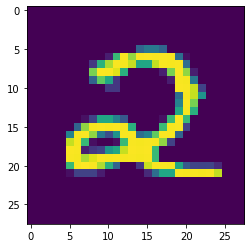

In [ ]:
rand = np.random.randint(0, all_labels.shape[0] -1)
plt.imshow(all_images[rand])
print(all_labels[rand])

The next cell will allow for the operations to happen on GPU, if CUDA is available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now the images and labels will be put into the format of a PyTorch Dataset.

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, labels, images, transform=None, target_transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        if self.transform:
          image = self.transform(image)
        if self.target_transform:
          label = self.target_transform(label)
        return image.to(device), label

With the definintion of the Dataset, we can now create a train and a test dataset, where the test dataset consists of 6000 images. We can then also initialize two PyTorch DataLoaders (one for training and one for testing) with a batch size of 64.

In [ ]:
training_data = CustomImageDataset(all_labels[:-6000], all_images[:-6000], transform=ToTensor())
test_data = CustomImageDataset(all_labels[-6000:], all_images[-6000:], transform=ToTensor())

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

And now we can finally define the architecture of the classifier.

In [ ]:
class CNN(nn.Module):                  #Score: 99.2%
    def __init__(self, out_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(     #Input 28*28*1     
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0), #Output 24*24*32                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2) #Output 12*12*32
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, tride=1, padding=0), #Output 10*10*64
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #Output 5*5*64              
        )
        self.dense = nn.Sequential(
            nn.Linear(5*5*64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, out_classes)
        )

    def forward(self, x):
        # Put through 2 convolution layers and a 3L deep linear network with dropouts
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) #Flatten
        output = self.dense(x)
        return output

With the architecture in place, we can now define how one training loop is supposed to look like.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device=device):
    model = model.to(device)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

And also how one test loop is supposed to look like.

In [ ]:
def test_loop(dataloader, model, loss_fn):
    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

With the training and test loop also in place we can now initialize the classifier, define its optimizer and then start to train it for ten epochs.

In [ ]:
model = CNN(12)

learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

From the test loop, we saw that the accuray was above 97% in the last epoch, which was good enough for our purpose. So we saved the resulting model to use it in the main Project Notebook.

In [ ]:
torch.save(model, '../resources/cnn.pth')